# Lumina Experiment Log 
hey everyone, in this experiment log you'll see the journey on how lumina is made. Lumina is intended to help Internal Auditors by incorporating GPT in their work process. Below you'll find step by step process the engine and logic behind Lumina. The engine will be placed inside python script node inside KNIME workflow.

## Importing and configuring necessary package
in order to API call to open AI make sure to configure everything including the type, base, version and the api key to variables. You can find necessary information about the configuration below in grab wiki onboarding GPT.

In [9]:
import os
import openai
from dotenv import load_dotenv

openai.api_type = "your api type"
openai.api_base = "your api base"
openai.api_version = "your api version"
openai.api_key = "your api key"

### Test your connection
make a simple chat completion script to test your connection. Keep in mind if it's not working you might need to contact your IT team to check whether your endpoint connection already configured on their backend.

In [10]:
from langchain.llms import AzureOpenAI

response = openai.ChatCompletion.create(
  engine="gpt-4",
  messages = [{
      "role": "system",
      "content": "You are an AI who likes to tell a dad joke"
  },
  {
      "role": "user",
      "content": "Try to joke in one simple sentence"
  }],
  temperature=0,
  max_tokens=350,
  top_p=0.95,
  frequency_penalty=0,
  presence_penalty=0,
  stop=None)

print(response["choices"][0]["message"].content)

Why don't scientists trust atoms? Because they make up everything!


## Working with embeddings and similarity search
If you're a frequent user of Open AI chatGPT you may have tried on copying a lot of words into the chatbox and asking them to summarize or even correct something. However, you may also notice that a standard chatGPT have **token limit** in which you can't put everything inside the chat box. That's where embeddings and similarity search come into play, with embeddings you can give the GPT only the necessary information to read instead of stuffing all of the words into it.

*To make it more understandable, imagine you're inside a library and you're searching for a specific book about Theory of Relativity. If you're not using embeddings it's like you're going through all sections inside the library to search for that book. If you're using embeddings however, you'll get a call number which tells you where to find that book location and starts from there*

In [11]:
#below are necessary packages to create embeddings
import os
from langchain.llms import AzureOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema.vectorstore import VectorStoreRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders.parsers.pdf import PDFPlumberParser
import pdfplumber
import pandas as pd

In [10]:
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders.parsers.pdf import PDFPlumberParser
import pdfplumber

# Open the PDF
pdf = pdfplumber.open(fr"/path_to_your_directory/Hercules Galactic System Access Review.pdf")

## Report Overview
To protect confidentiality, the audit report that I use is a nonsense document discussing nonsense topic. Here's the overview of the document.

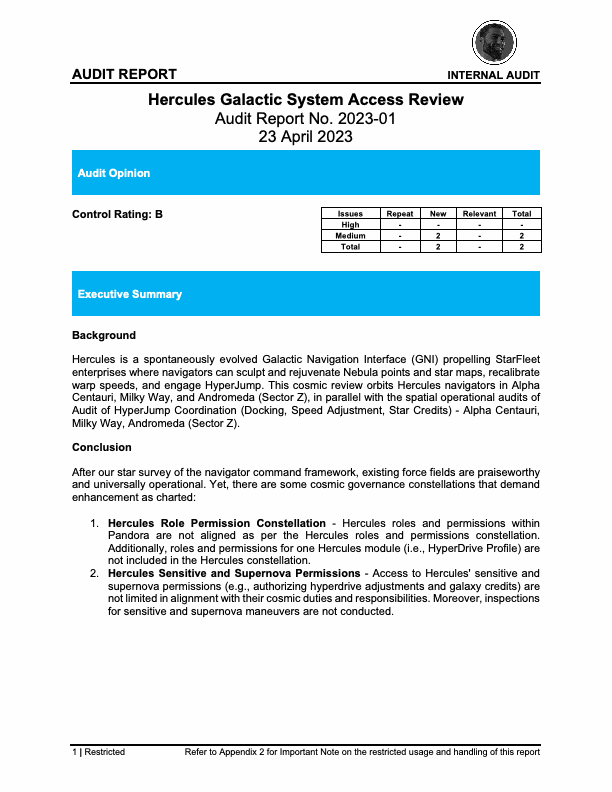

In [15]:
p0 = pdf.pages[0]
im = p0.to_image()
im

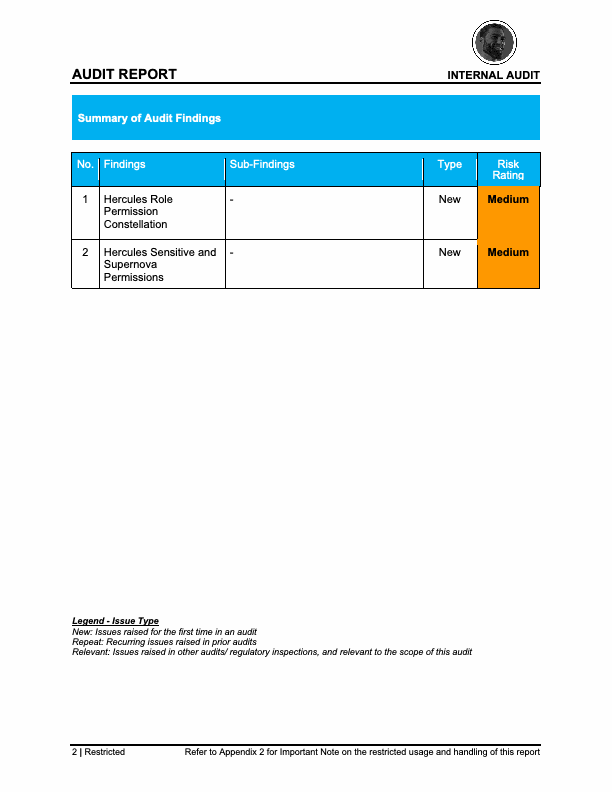

In [11]:
p0 = pdf.pages[1]
im = p0.to_image()
im

## Data Cleansing
In order to get the best result for the embeddings, we need to clean up the data first. The cleaner the data the better the result will be.

In [1]:
import os
import openai
from dotenv import load_dotenv
import os
from langchain.llms import AzureOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema.vectorstore import VectorStoreRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders.parsers.pdf import PDFPlumberParser
import pdfplumber
import pandas as pd


def risk_rating(n):
    Issues = pdf.pages[n].extract_table()
    issues_data = pd.DataFrame(Issues[1:], columns=Issues[0])
    sentences = []

    issue_rating = issues_data['Issues']
    attributes = list(issues_data.columns.values)

    for i in range(0, len(issue_rating)):
        for j in range(1, len(attributes)):
            if (i == max(range(0,len(issue_rating))) and j == max(range(1, len(attributes)))):
                sentences.append(f"There are grand total of {issues_data.iloc[i,j]} issues".replace("-","0"))
            else:
                sentences.append(f"There are {issues_data.iloc[i,j]} {attributes[j]} {issue_rating[i]} issues".replace("-","0"))
    for sentence in sentences:
        print(sentence)

def exec_summary(n):
    start_text = "Executive Summary"
    start_index = text.find(start_text)
    end_text = f"{n+1} | "
    end_index = text.find(end_text)

    if start_index != -1:
        extracted_text = text[start_index:end_index]
        print(extracted_text)
    else:
        print("Start text not found in the string.")
        
def generate_sentence_list(table):
    headers = list(summary_table_dict.keys())  
    num_rows = len(next(iter(summary_table_dict.values())))

    sentence_list = []
    for i in range(num_rows):
        sentence = ', '.join([f'{header}:{summary_table_dict[header][i]}' for header in headers])
        sentence_list.append(sentence)

    return sentence_list

def summary_table_extractor(n):
    summary_table = pdf.pages[n].extract_table()
    summary_table_dict = {}
    summary_table_data = pd.DataFrame(summary_table[1:], columns=summary_table[0])
    
    #pardon my code, this is because the table structure when read by pdfreader is quite weird
    for k in range(0, summary_table_data.shape[1]):
        data_to_dict = summary_table_data.iloc[:, k].tolist()
        data_to_dict_filtered = [x.replace('\n',' ') for x in data_to_dict if x is not None and x != '']
        if k == 0:
            summary_table_dict.update({"No": data_to_dict_filtered[1:]})
        elif k == 1:
            summary_table_dict.update({"Findings": data_to_dict_filtered[1:]})
        elif k == 2:
            summary_table_dict.update({"Sub-Findings": data_to_dict_filtered[1:]})
        elif k == 3:
            summary_table_dict.update({"Type": data_to_dict_filtered[1:]})
        elif k == 4:
            summary_table_dict.update({"Risk Rating": data_to_dict_filtered[0:]})
        elif k == 5:
            break
        
    return generate_sentence_list(summary_table_dict)

def process_tables(*tables):
    def clean(value):
        return value if value not in (None, '') else ''

    result = []
    current_issue = {}

    for table in tables:
        for row in table:
            row = [clean(cell) for cell in row]  

            if len(row) >= 4 and row[0] and row[2]: 
                if current_issue:
                    result.append([
                        current_issue['parent_issue'],
                        current_issue['issue_type'],
                        current_issue['risk_rating'],
                        current_issue['issue_owner'],
                        current_issue['issue_details']
                    ])
                current_issue = {
                    'parent_issue': row[0],
                    'issue_type': row[2],
                    'risk_rating': '',
                    'issue_owner': '',
                    'issue_details': []
                }
            elif len(row) >= 4 and row[3]:
                current_issue['risk_rating'] = row[3]
            elif len(row) >= 4 and row[0].startswith('Issue Owner'): 
                current_issue['issue_owner'] = row[0]
            elif len(row) >= 2:
                content = row[0]
                action_remediation = row[1]
                if content or action_remediation:
                    if current_issue['issue_details'] and (content.startswith('Action Remediation') or action_remediation.startswith('Action Owner')):
                        last_detail = current_issue['issue_details'][-1]
                        last_detail[1] += ' ' + action_remediation
                    elif current_issue['issue_details'] and (content == '' or action_remediation == ''):
                        if content == '':
                            last_detail = current_issue['issue_details'][-1]
                            last_detail[1] += ' ' + action_remediation
                        else:
                            last_detail = current_issue['issue_details'][-1]
                            last_detail[0] += ' ' + content
                    else:
                        current_issue['issue_details'].append([content, action_remediation])

    if current_issue:
        result.append([
            current_issue['parent_issue'],
            current_issue['issue_type'],
            current_issue['risk_rating'],
            current_issue['issue_owner'],
            current_issue['issue_details']
        ])

    return result

def convert_details(details):
    return '; '.join([', '.join(detail) for detail in details])


def generate_paragraph(row):
    return f"""The parent issue is '{row['parent_issue']}'
The issue type is {row['issue_type'].capitalize()}
The risk rating is {row['risk_rating']}
The issue owner is '{row['issue_owner']}'
The issue details are '{row['issue_details']}'\n"""

def summary_table_extractor(n):
    summary_table = pdf.pages[n].extract_table()
    summary_table_dict = {}
    summary_table_data = pd.DataFrame(summary_table[1:], columns=summary_table[0])
    
    for k in range(0, summary_table_data.shape[1]):
        data_to_dict = summary_table_data.iloc[:, k].tolist()
        data_to_dict_filtered = [x.replace('\n',' ') for x in data_to_dict if x is not None and x != '']
        if k == 0:
            summary_table_dict.update({"No": data_to_dict_filtered[1:]})
        elif k == 1:
            summary_table_dict.update({"Findings": data_to_dict_filtered[1:]})
        elif k == 2:
            summary_table_dict.update({"Sub-Findings": data_to_dict_filtered[1:]})
        elif k == 3:
            summary_table_dict.update({"Type": data_to_dict_filtered[1:]})
        elif k == 4:
            summary_table_dict.update({"Risk Rating": data_to_dict_filtered[0:]})
        elif k == 5:
            break
        
    return generate_sentence_list(summary_table_dict)

n = 1

def generate_sentence_list(table):
    headers = list(table.keys())  # Get the headers from the dictionary keys
    num_rows = len(next(iter(table.values())))  # Get the number of rows

    sentence_list = []
    for i in range(num_rows):
        sentence = ', '.join([f'{header}:{table[header][i]}' for header in headers])
        sentence_list.append(sentence)

    return sentence_list

def summary_table_extractor(n):
    summary_table = pdf.pages[n].extract_table()
    summary_table_dict = {}
    summary_table_data = pd.DataFrame(summary_table[1:], columns=summary_table[0])
    
    for k in range(0, summary_table_data.shape[1]):
        data_to_dict = summary_table_data.iloc[:, k].tolist()
        data_to_dict_filtered = [x.replace('\n',' ') for x in data_to_dict if x is not None and x != '']
        if k == 0:
            summary_table_dict.update({"No": data_to_dict_filtered[1:]})
        elif k == 1:
            summary_table_dict.update({"Findings": data_to_dict_filtered[1:]})
        elif k == 2:
            summary_table_dict.update({"Sub-Findings": data_to_dict_filtered[1:]})
        elif k == 3:
            summary_table_dict.update({"Type": data_to_dict_filtered[1:]})
        elif k == 4:
            summary_table_dict.update({"Risk Rating": data_to_dict_filtered[0:]})
        elif k == 5:
            break
        
    return generate_sentence_list(summary_table_dict)

## Testing the cleaned data
Check out the result of the cleaned audit report data. This should improve the performance when embeddings come into play.

In [8]:
pdf = pdfplumber.open(fr"/path_to_your_directory/Hercules Galactic System Access Review.pdf")
text = pdf.pages[0].extract_text()

risk_rating(0)
exec_summary(0)

for n in summary_table_extractor(1):
    print(n)

aggregate_tables = []

for n in range(2,5):
    table=pdf.pages[n].extract_tables(table_settings={"vertical_strategy": "lines", 
                                               "horizontal_strategy": "lines"})

    aggregate_tables.append(table)

new_list = []

for n in aggregate_tables:
    for x in n:
        for z in x:
            if len(z) == 2 or len(z) ==4:
                new_list.append(z)
            else:
                pass

new_new_list = [new_list]
            
            
# Process the filtered tables
results = process_tables(*new_new_list)
data = []

for item in results:
    # Extract the first four elements
    row = item[:4]
    # Convert the nested lists in the fifth element to a string representation
    issue_details = convert_details(item[4])
    # Append the issue details to the row
    row.append(issue_details)
    # Append the row to the data list
    data.append(row)

cleaned_data = [[s.replace('\n', ' ') for s in sublist] for sublist in data]

# Define the column names
columns = ['parent_issue', 'issue_type', 'risk_rating', 'issue_owner', 'issue_details']

# Create the DataFrame
df = pd.DataFrame(cleaned_data, columns=columns)

paragraphs = "\n".join(df.apply(generate_paragraph, axis=1))

print("\n" + paragraphs)

There are 0 Repeat High issues
There are 0 New High issues
There are 0 Relevant High issues
There are 0 Total High issues
There are 0 Repeat Medium issues
There are 2 New Medium issues
There are 0 Relevant Medium issues
There are 2 Total Medium issues
There are 0 Repeat Total issues
There are 2 New Total issues
There are 0 Relevant Total issues
There are grand total of 2 issues
Executive Summary
Background
Hercules is a spontaneously evolved Galactic Navigation Interface (GNI) propelling StarFleet
enterprises where navigators can sculpt and rejuvenate Nebula points and star maps, recalibrate
warp speeds, and engage HyperJump. This cosmic review orbits Hercules navigators in Alpha
Centauri, Milky Way, and Andromeda (Sector Z), in parallel with the spatial operational audits of
Audit of HyperJump Coordination (Docking, Speed Adjustment, Star Credits) - Alpha Centauri,
Milky Way, Andromeda (Sector Z).
Conclusion
After our star survey of the navigator command framework, existing force fiel

# Continuous Loop in KNIME
The next part will be using KNIME to continuously loop the code above (don't forget to adjust the code) and save the document into pdf. Use the pyton node and paste the code below to get the vector store from all of the transformed document

In [2]:
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema.vectorstore import VectorStoreRetriever

loader = PyPDFDirectoryLoader(fr"/path_to_your_directory")
pages = loader.load_and_split()
faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings(openai_api_type = "your api type",
                                                                   model = "your text model",
                                                                   deployment= "your deployment",
                                                                   openai_api_base = "your api base",
                                                                   openai_api_version = "your api version",
                                                                   openai_api_key = "your api key"))